<a href="https://colab.research.google.com/github/ProvenDruid/FFN-projects/blob/main/ffn_addingMachine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split


import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
from matplotlib_inline.backend_inline import set_matplotlib_formats

In [ ]:
data_np = np.random.randint(-10, 11, size=(1000,2))
dataNorm = data_np / np.max(data_np)##
labels_np=np.sum(data_np, axis=1)
dataTensor = torch.tensor(dataNorm).float() ##  dataTensor = torch.tensor(data_np).float()
labelsTensor = torch.tensor(labels_np).float()
labelsTensor=labelsTensor[:,None]

In [ ]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataTensor, labelsTensor, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 20
train_loader = DataLoader(train_dataDataset,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

array([-1,  0,  4,  6, -2])

In [ ]:
# create a class for the model
def createTheAddNet():

  class addNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(2,40)

      ### hidden layer
      self.fc1 = nn.Linear(40,40)
      self.fc2 = nn.Linear(40,40)

      ### output layer
      self.output = nn.Linear(40,1)

    # forward pass
    def forward(self,x):
      x = self.input(x)
      x = self.fc1(x)
      x = self.fc2(x)

      return self.output(x)

  # create the model instance
  net = addNet()

  # loss function
  lossfun = nn.MSELoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.01)

  return net,lossfun,optimizer

In [ ]:
# a function that trains the model

# global parameter
numepochs = 10

def trainTheModel():

  # create a new model
  net,lossfun,optimizer = createTheAddNet()

  # initialize losses
  trainAcc=[]
  testAcc=[]
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    net.train()

    # loop over training data batches
    batchAcc=[]
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      #compute accuracy
      accOfBatch=(yHat.round()==y).float()
      #accOfBatch=(np.round(yHat,2)==y).float()
      accOfBatchPercentage=100*torch.mean(accOfBatch)
      batchAcc.append(accOfBatchPercentage)

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)
    #accuracy of each epoch
    trainAcc.append( np.mean(batchAcc) )

    # test accuracy
    net.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)

    accOfTest=(yHat.round()==y).float()
    #accOfTest=(np.round(yHat,2)==y).float()
    accOfTestPercentage=100*torch.mean(accOfTest)
    testAcc.append(accOfTestPercentage)
    testLoss[epochi] = lossfun(yHat,y).item()

  # function output
  return trainLoss,testLoss,trainAcc,testAcc,net

In [ ]:
trainLoss, testLoss, trainAcc, testAcc, theNet = trainTheModel()

tensor(100.)


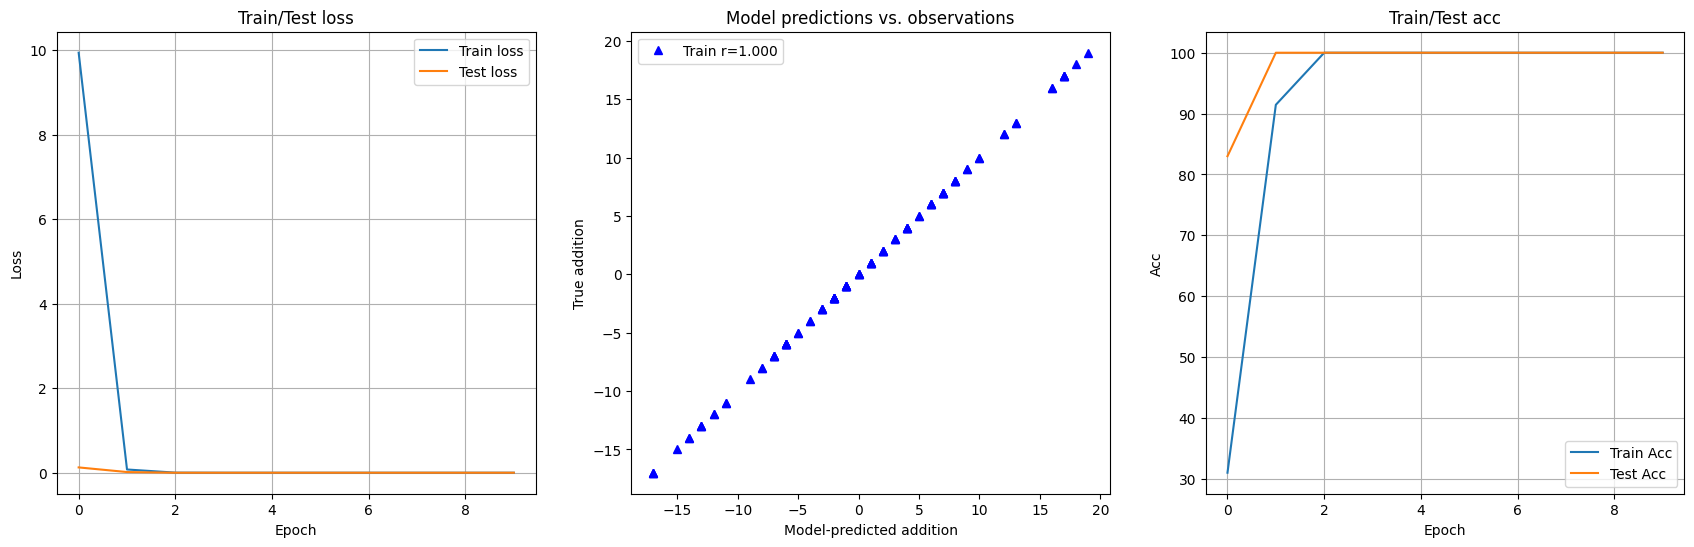

In [ ]:
# plot some results
fig,ax = plt.subplots(1,3,figsize=(21,6))

ax[0].plot(trainLoss,label='Train loss')
ax[0].plot(testLoss,label='Test loss')
ax[0].set_title('Train/Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()
ax[0].grid()


# show predictions and real values
yHatTrain = theNet(train_data)
yHatTest  = theNet(test_data)

#ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted addition')
ax[1].set_ylabel('True addition')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

#accuracy
ax[2].plot(trainAcc,label='Train Acc')
ax[2].plot(testAcc,label='Test Acc')
ax[2].set_title('Train/Test acc')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Acc')
ax[2].legend()
ax[2].grid()
print(100*torch.mean((((yHatTest.round()-test_labels).abs())<3).float()))
plt.show()

In [ ]:
test_data[-5:]

tensor([[-0.8000,  0.9000],
        [ 0.1000,  0.1000],
        [ 0.6000,  1.0000],
        [ 0.9000, -1.0000],
        [ 0.3000,  0.4000]])

In [ ]:
yHatTest[-5:]

tensor([[ 1.0000],
        [ 2.0000],
        [16.0000],
        [-1.0000],
        [ 7.0000]], grad_fn=<SliceBackward0>)

In [ ]:
test_labels[-5:]

tensor([[ 1.],
        [ 2.],
        [16.],
        [-1.],
        [ 7.]])